# The Battle of Neighborhoods

### Finding a Better Place in Neighborhoods of Toronto¶

<h3>Installing and importing libraries</h3>

In [1]:
!pip install bs4
!pip install requests
!pip install html5lib
!pip install folium

  Stored in directory: /home/dsxuser/.cache/pip/wheels/a0/b0/b2/4f80b9456b87abedbc0bf2d52235414c3467d8889be38dd472
Successfully built bs4
     |████████████████████████████████| 102kB 7.6MB/s ta 0:00:011


In [2]:
from bs4 import BeautifulSoup
import pandas as pd
import requests
from geopy.geocoders import Nominatim
import folium
from sklearn.cluster import KMeans
from IPython.display import HTML
import base64  
import pandas as pd 
from sklearn import preprocessing
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, jaccard_similarity_score, f1_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
import random as r
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

<h3>Defining some functions</h3>

In [3]:
def create_download_link( df, title = "Download CSV file", filename = "data.csv"):  
    csv = df.to_csv(index =False)
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

#create_download_link(df_new)

In [4]:
#Get Latitude and longitude values of Neighborhood
def getCoordinates(neigh):
    address = '{}, Toronto'.format(neigh)
    geolocator = Nominatim(user_agent="t_explorer")
    latLong = geolocator.geocode(address)
    latLong = [latLong.latitude, latLong.longitude]
    return latLong

In [5]:
#Function to get URL for each neighborhood (explore)

LIMIT = 200 # limit of number of venues returned by Foursquare API
radius = 1000 # Radius of Search

def getURL(lat, long):

    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        lat, 
        long, 
        radius, 
        LIMIT)
    return url

In [6]:
#function to generate random colors
def randomColor():
    colorArr = ['00','11','22','33','44','55','66','77','88','99','AA','BB','CC','DD','EE','FF']
    color = '#' + colorArr[r.randint(0,15)] + colorArr[r.randint(0,15)] + colorArr[r.randint(0,15)]
    return color

<h3>Get toronto neighborhood data from wikipedia</h3>

In [7]:
#Link of wikipedia Pages for Toronto Postal codes
URL = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
webpage = requests.get(URL) 

In [8]:
#Covert page to BeautifulSoup Object and extract the table
soup = BeautifulSoup(webpage.content, 'html5lib') 
table = soup.find('tbody')

In [9]:
#Load table data to a dataframe
postalArr = []
boroughArr = []
hoodArr = []

for ind, row in enumerate(table.findAll('tr')):
    if (ind == 0):
        continue
    else:
        postalArr.append(row.findChildren()[0].text[:-1])
        boroughArr.append(row.findChildren()[1].text[:-1])
        hoodArr.append(row.findChildren()[2].text[:-1])

torontoDict = {'Postal_Code':postalArr, 'Borough':boroughArr, 'Neighborhood':hoodArr}
df = pd.DataFrame(torontoDict)

#Clean the dataframe
df = df[df['Borough'] != 'Not assigned'].reset_index(drop = True)

#Dataframe from wikipedia Table is created
display(df.head())
print('Shape : ',df.shape)

,Postal_Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


Shape :  (103, 3)


In [10]:
#This dataframe splits all the Neighborhood
df2 = pd.DataFrame(columns=['Postal_Code', 'Borough', 'Neighborhood'])

for i in range(len(df)):
    postal_code = df.loc[i,'Postal_Code']
    borough = df.loc[i,'Borough']
    hoodlist = df.loc[i,'Neighborhood']
    
    for j in hoodlist.split('/'):
        df2 = df2.append({'Postal_Code': postal_code, 'Borough': borough, 'Neighborhood': j.strip()}, ignore_index=True)

df2 = df2.drop_duplicates(subset ="Neighborhood", keep = 'first')
df2 = df2.sort_values('Neighborhood').reset_index(drop=True)

display(df2.head())
print(df2.shape)

#Dataframe df2 is created
#Dataframe is cleaned and sorted

,Postal_Code,Borough,Neighborhood
0,M1S,Scarborough,Agincourt
1,M8W,Etobicoke,"Alderwood, Long Branch"
2,M3H,North York,"Bathurst Manor, Wilson Heights, Downsview North"
3,M2K,North York,Bayview Village
4,M5M,North York,"Bedford Park, Lawrence Manor East"


(99, 3)


In [11]:
#get location coordinates of neighborhoods

lat_arr = []
long_arr = []
i = 0

for neigh in df2['Neighborhood']:
    latLong = [None, None]
    try:
        latLong = getCoordinates(neigh)
    except:
        pass
    lat_arr.append(latLong[0])
    long_arr.append(latLong[1])
    i += 1
    print(i, end= " ")
    
df2['Latitude'] = lat_arr
df2['Longitude'] = long_arr

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

In [13]:
#drop non existing and duplicate latitude and longitude containing rows
df2 = df2.dropna()
df2 = df2.drop_duplicates(subset ="Latitude", keep = 'first')
df2 = df2.drop_duplicates(subset ="Longitude", keep = 'first').reset_index(drop = True)

display(df2.head())
print('Shape', df2.shape)

,Postal_Code,Borough,Neighborhood,Latitude,Longitude
0,M1S,Scarborough,Agincourt,43.785353,-79.278549
1,M8W,Etobicoke,"Alderwood, Long Branch",43.601717,-79.545232
2,M2K,North York,Bayview Village,43.769197,-79.376662
3,M5E,Downtown Toronto,Berczy Park,43.647984,-79.375396
4,M1H,Scarborough,Cedarbrae,43.756467,-79.226692


Shape (50, 5)


In [14]:
#Get Latitude and longitude values of Toronto
torontoStr = 'Toronto, Ontario'
geolocator = Nominatim(user_agent="t_explorer")
locationToronto = geolocator.geocode(torontoStr)
locationToronto = [locationToronto.latitude, locationToronto.longitude]
print(locationToronto)

[43.6534817, -79.3839347]


In [15]:
#Create map of toronto and mark the postal codes along with 1000m radius around them

map_Toronto = folium.Map(location= locationToronto, zoom_start=10)

for lat, long in zip(df2['Latitude'], df2['Longitude']):
   
    folium.Circle([lat, long],
                  radius=1000,
                  color = '#ffd633',
                  opacity = 0.2,
                  fill_color = '#ffd633',
                  fill_opacity = 0.2,
                   ).add_to(map_Toronto)
    
for pc, bor, neigh, lat, long in zip(df2['Postal_Code'], df2['Borough'], df2['Neighborhood'], df2['Latitude'], df2['Longitude']):
    label = '{}, {}, {}'.format(neigh, bor, pc)
    
    folium.CircleMarker(
        [lat, long],
        radius=5,
        popup=label,
        color = '#ff3333',
        fill_color = '#ff3333',
        fill_opacity = 1,
        parse_html=False).add_to(map_Toronto)

#Map displayed Later

In [16]:
# @hidden_cell
# Credentials to access foursquare API
CLIENT_ID = 'HA0K14L5LOTDQATNDC3RFLKNA0LWITWPPPEUPINT1OEE2NUW' # your Foursquare ID
CLIENT_SECRET = 'GQ241IN5EYZS1QMUZT3S10YUO5DZA3JPGX1HCBTJM33ZSPXY' # your Foursquare Secret
VERSION = '20200408' # Foursquare API version

<h3>Get venues in neighborhood using foursquare API</h3>

In [17]:
#Create a new dataframe to store the venue data along with the previous data
df3Columns = list(df2.columns)
addColumns = ['Venue', 'VLatitude', 'VLongitude', 'Category']
df3Columns.extend(addColumns)

df3 = pd.DataFrame(columns = df3Columns)

#Loop over each Postal Code
for row in range(len(df2)):
    pc = df2.loc[row, 'Postal_Code']
    bor = df2.loc[row, 'Borough']
    neigh = df2.loc[row, 'Neighborhood']
    lat = df2.loc[row, 'Latitude']
    long = df2.loc[row, 'Longitude']
    
    try:
        url = getURL(lat,long)
        results = requests.get(url).json()
        itemsDict = results['response']['groups'][0]['items']
    except:
        continue
    
    #Loop over every venue in each postal code
    for item in itemsDict:
        try:
            venueName = item['venue']['name']
            vLat = float(item['venue']['location']['lat'])
            vLong = float(item['venue']['location']['lng'])
            category = item['venue']['categories'][0]['name']

            newRow = [pc, bor, neigh, lat, long, venueName, vLat, vLong, category]
            
            #Append data to the new dataFrame
            df3 = df3.append(pd.Series(newRow, index = df3Columns), ignore_index = True)
        except:
            continue
    
    print(row, end= " ")

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

In [18]:
#drop 'neighborhood' venue categories

df3 = df3[df3['Category'] != 'Neighborhood'].reset_index(drop = True)
display(df3.head())
print(df3.shape)
print('Number of neighborhoods : {}'.format(len(df3['Neighborhood'].unique())))
print('Number of venue categories : {}'.format(len(df3['Category'].unique())))

,Postal_Code,Borough,Neighborhood,Latitude,Longitude,Venue,VLatitude,VLongitude,Category
0,M1S,Scarborough,Agincourt,43.785353,-79.278549,One2 Snacks,43.787048,-79.276658,Asian Restaurant
1,M1S,Scarborough,Agincourt,43.785353,-79.278549,Tim Hortons,43.785637,-79.279215,Coffee Shop
2,M1S,Scarborough,Agincourt,43.785353,-79.278549,In Cheon House Korean & Japanese Restaurant 인천관,43.786468,-79.275693,Korean Restaurant
3,M1S,Scarborough,Agincourt,43.785353,-79.278549,Yummy Cantonese Restaurant 老西関腸粉,43.787568,-79.269585,Cantonese Restaurant
4,M1S,Scarborough,Agincourt,43.785353,-79.278549,Wonton Chai Noodle 雲吞仔,43.787722,-79.269552,Noodle House


(2716, 9)
Number of neighborhoods : 50
Number of venue categories : 287


In [19]:
#Remove neighborhoods from df2 whose data doesnt exist in df3(due to some errors)
missing = [i for i in df2['Neighborhood'] if i not in df3['Neighborhood'].unique()]
df2 = df2[~df2['Neighborhood'].isin(missing)]

<h3>Convert venues to categoricial variables</h3>

In [20]:
#Create new dataframe of the postal codes and the Categorical Variables of 'Category'
toronto_df = pd.get_dummies(df3[['Category']], prefix="", prefix_sep="")
toronto_df = toronto_df.reindex(sorted(toronto_df.columns), axis=1)
toronto_df.insert(0, 'Neighborhood', df3[['Neighborhood']])
toronto_df = toronto_df.groupby('Neighborhood').mean().reset_index()

In [21]:
display(toronto_df.head())
print(toronto_df.shape)

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Amphitheater,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio
0,Agincourt,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,...,0.00,0.0,0.0,0.025000,0.0,0.0,0.0,0.0,0.000000,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,...,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
2,Bayview Village,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,...,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
3,Berczy Park,0.0,0.0,0.02,0.0,0.0,0.0,0.02,0.0,0.0,...,0.01,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
4,Cedarbrae,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,...,0.00,0.0,0.0,0.026316,0.0,0.0,0.0,0.0,0.026316,0.0


(50, 288)


<h3>KMeans clustering to cluster neighborhoods together</h3>

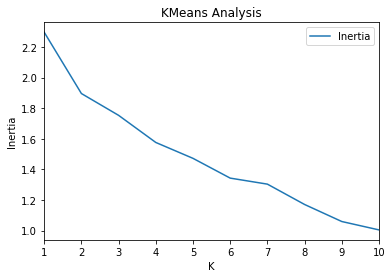

In [22]:
#Model to create clusters
df_modeldata = toronto_df.drop('Neighborhood',axis = 1)

#Choosing the best K using elbow method
k_kmeans = [(i+1) for i in range(10)]
inertia_arr = []

for k in k_kmeans:
    kMeansModel = KMeans(init = "k-means++", n_clusters = k, n_init = 10)
    kMeansModel.fit(df_modeldata)
    inertia_arr.append(kMeansModel.inertia_)
    
df_dict = {'K':k_kmeans, 'Inertia': inertia_arr}
df_kMeans = pd.DataFrame(df_dict)
df_kMeans.plot(kind='line',x = 'K', y='Inertia', xticks = k_kmeans)
plt.title('KMeans Analysis')
plt.xlabel('K')
plt.ylabel('Inertia')
plt.show()


In [23]:
#Choosing the best k as 8 and creating model
best_k_kMeans = 8
kMeansModel = KMeans(init = "k-means++", n_clusters = best_k_kMeans, n_init = 10)
kMeansModel.fit(df_modeldata)
clustered_arr = kMeansModel.labels_

<h4><font color='red'>Cluster Table - Important</font></h4>

In [24]:
df2['Cluster'] = clustered_arr
display(df2.head())
print(df2.shape)

,Postal_Code,Borough,Neighborhood,Latitude,Longitude,Cluster
0,M1S,Scarborough,Agincourt,43.785353,-79.278549,6
1,M8W,Etobicoke,"Alderwood, Long Branch",43.601717,-79.545232,4
2,M2K,North York,Bayview Village,43.769197,-79.376662,1
3,M5E,Downtown Toronto,Berczy Park,43.647984,-79.375396,1
4,M1H,Scarborough,Cedarbrae,43.756467,-79.226692,4


(50, 6)


In [25]:
#CREATE CLUSTER MAP

clusters_map = folium.Map(location = locationToronto, zoom_start = 10)
colors = [randomColor() for i in range(best_k_kMeans)]

for pc, lat, long, cluster in zip(df2['Postal_Code'], df2['Latitude'], df2['Longitude'], df2['Cluster']):
    label = 'Cluster{}, {}, {}'.format(cluster, neigh, bor)
    
    folium.CircleMarker(
        [lat, long],
        radius=5,
        popup=label,
        color = '#FFFFFF',
        weight = 2,
        fill_color = colors[cluster],
        fill_opacity = 1,
        parse_html=False).add_to(clusters_map)

#Map displayed later

<h3>KNN Classification to classify the new location given by user</h3>

In [26]:
X = df_modeldata.values
Y= df2['Cluster'].values

<h4><font color='red'>Testing the model - Important</font></h4>

,K,Accuracy,F1 Score
0,1,80.0,82.87
1,2,70.0,82.35
2,3,70.0,82.35
3,4,70.0,82.35
4,5,70.0,82.35
5,6,70.0,82.35
6,7,70.0,82.35
7,8,70.0,82.35
8,9,70.0,82.35
9,10,70.0,82.35


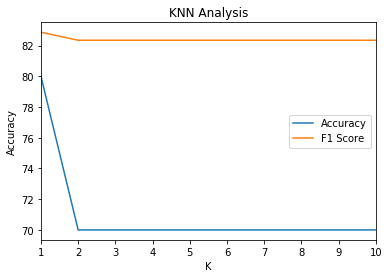

In [27]:
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size = 0.2, random_state=1)

k_kNN = [(i+1) for i in range(10)]
acc_arr = []
f1_arr = []

for k in k_kNN:
    kNNmodel = KNeighborsClassifier(n_neighbors = k)
    kNNmodel.fit(x_train,y_train)
    yhat_kNN = kNNmodel.predict(x_test)

    acc_arr.append(accuracy_score(y_test,yhat_kNN).round(4)*100)
    f1_arr.append(f1_score(y_test,yhat_kNN, average = 'weighted', labels=np.unique(yhat_kNN)).round(4)*100)

df_dict = {'K':k_kNN,'Accuracy':acc_arr, 'F1 Score':f1_arr}
df_kNN = pd.DataFrame(df_dict)

display(df_kNN)
df_kNN.plot(kind='line',x='K',y=['Accuracy', 'F1 Score'])
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.title('KNN Analysis')
plt.show()


In [28]:
#k = 1 is the best k, Therefore
best_k_kNN = 3
kNNmodel = KNeighborsClassifier(n_neighbors = best_k_kNN)
kNNmodel.fit(x_train,y_train)
print('Classification Report :')
print (classification_report(y_test, kNNmodel.predict(x_test)))
print('The cross validation score is : ',cross_val_score(kNNmodel, X, Y, cv=5).mean().round(3))

Classification Report :
              precision    recall  f1-score   support

           1       0.70      1.00      0.82         7
           4       0.00      0.00      0.00         2
           7       0.00      0.00      0.00         1

   micro avg       0.70      0.70      0.70        10
   macro avg       0.23      0.33      0.27        10
weighted avg       0.49      0.70      0.58        10

The cross validation score is :  0.771


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


In [29]:
#Using entire dataset to train the model
kNNmodel = KNeighborsClassifier(n_neighbors = best_k_kNN)
kNNmodel.fit(X,Y)
yhat_kNN = kNNmodel.predict(X)

<h3> Create a new dataframe for the current neighborhood and its venues</h3>

In [30]:
#Get Latitude and longitude values of current neighborhood
currentNeighName = 'Connaught Place, New Delhi'
geolocator = Nominatim(user_agent="t_explorer")
locationCurrent = geolocator.geocode(currentNeighName)
locationCurrent = [locationCurrent.latitude, locationCurrent.longitude]
print(locationCurrent)

[28.6313827, 77.2197924]


In [31]:
#Create empty dataframe to store the current neighborhood venues
currentColumns = ['Neighborhood', 'Latitude', 'Longitude']
currentColumns.extend(addColumns)
df_current = pd.DataFrame(columns = currentColumns)
df_current

,Neighborhood,Latitude,Longitude,Venue,VLatitude,VLongitude,Category


In [32]:
#Get the current URL
try:
    lat = locationCurrent[0]
    long = locationCurrent[1]
    currentURL = getURL(lat, long)
    results = requests.get(currentURL).json()
    itemsDict = results['response']['groups'][0]['items']
except:
    pass

#Loop over every venue in the neighborhood
for i,item in enumerate(itemsDict):
    try:
        venueName = item['venue']['name']
        vLat = float(item['venue']['location']['lat'])
        vLong = float(item['venue']['location']['lng'])
        category = item['venue']['categories'][0]['name']

        newRow = [currentNeighName, lat, long, venueName, vLat, vLong, category]

        #Append data to the new dataFrame
        df_current = df_current.append(pd.Series(newRow, index = currentColumns), ignore_index = True)
        print(i, end= " ")
        
    except:
        continue



0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 

In [33]:
display(df_current.head())
print(df_current.shape)

,Neighborhood,Latitude,Longitude,Venue,VLatitude,VLongitude,Category
0,"Connaught Place, New Delhi",28.631383,77.219792,Connaught Place | कनॉट प्लेस (Connaught Place),28.632731,77.220018,Plaza
1,"Connaught Place, New Delhi",28.631383,77.219792,Starbucks,28.632011,77.217731,Coffee Shop
2,"Connaught Place, New Delhi",28.631383,77.219792,Rajdhani Thali,28.629999,77.220401,Indian Restaurant
3,"Connaught Place, New Delhi",28.631383,77.219792,Wenger's,28.633412,77.218292,Bakery
4,"Connaught Place, New Delhi",28.631383,77.219792,Fabindia,28.632012,77.217729,Clothing Store


(79, 7)


<h3>Convert current neighborhood venues to categorical variables, add columns which are in KMeans model, drop columns which are not</h3>

In [34]:
#Create new dataframe of the current neighborhood categorical Variable 
currentNeigh = pd.get_dummies(df_current[['Category']], prefix="", prefix_sep="")
currentNeigh.insert(0, 'Neighborhood', df_current[['Neighborhood']])
currentNeigh = currentNeigh.groupby('Neighborhood').mean().reset_index()
currentNeigh = currentNeigh.drop('Neighborhood',axis = 1)

torontoVenues = list(df_modeldata.columns)
currentVenues = list(currentNeigh.columns)

dropVenues = [i for i in currentVenues if i not in torontoVenues]
addVenues = [i for i in torontoVenues if i not in currentVenues]

currentNeigh = currentNeigh.drop(dropVenues,axis = 1)
currentNeigh = currentNeigh.join(pd.DataFrame(0, index=currentNeigh.index, columns=addVenues))
currentNeigh = currentNeigh.reindex(sorted(currentNeigh.columns), axis=1)

In [35]:
display(currentNeigh.head())
print(currentNeigh.shape)

,Afghan Restaurant,African Restaurant,American Restaurant,Amphitheater,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0.025316,...,0,0,0,0,0,0,0,0,0,0


(1, 287)


<h3>Predict cluster and generate similarity score</h3>

In [36]:
#predict the current neighborhood cluster

similarCluster = kNNmodel.predict(currentNeigh.values)[0]
print('This belongs to cluster : ', similarCluster)

This belongs to cluster :  1


In [39]:
#toronto_Df contains the toronto neighborhoods and their venue categorical variables
import scipy
neighborslist = list(df2[df2['Cluster'] == similarCluster]['Neighborhood'])
neighbors_df = toronto_df[toronto_df['Neighborhood'].isin(neighborslist)]
neighbors_df = neighbors_df.reset_index(drop=True)

#create new dataframe to store the neighborhood names which belong to current neighborhood cluster
neighbors_names = neighbors_df[['Neighborhood']]

#keep only their categorical variables (of same cluster toronto neighborhoods)
neighbors_df = neighbors_df.drop('Neighborhood', axis = 1)

#find correlation and distance between new neighborhood and in-cluster neighborhoods
corr_arr = []
dist_arr = []

for i in range(len(neighbors_df)):
    corr_arr.append((currentNeigh.loc[0,:]).corr(neighbors_df.loc[i,:]))

dist_arr = scipy.spatial.distance.cdist(neighbors_df.iloc[:,:], currentNeigh.iloc[0:1,:], metric='euclidean')

neighbors_names['Distance'] = dist_arr
neighbors_names['Correlation'] = corr_arr

#find the correlation between the two dataframes and hence the similarity
neighbors_names = neighbors_names.sort_values('Correlation', ascending = False).reset_index(drop = True)
top_10 = neighbors_names.head(10)
top_10['Similarity'] = top_10['Correlation'].round(2)*100
top_10 = top_10.drop('Correlation', axis = 1)

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


<h4><font color='red'>Similarity Score - Important</font></h4>

In [40]:
#get the top 10 similar neighborhoods and their coordinates
top_10 = (pd.merge(left=top_10, right=df2[['Neighborhood', 'Latitude', 'Longitude']], how='left', left_on='Neighborhood', right_on='Neighborhood')).head(10)
display(top_10)

,Neighborhood,Distance,Similarity,Latitude,Longitude
0,"Dufferin, Dovercourt Village",0.217766,43.0,43.660202,-79.435719
1,Hillcrest Village,0.213072,40.0,43.681695,-79.425712
2,"Runnymede, The Junction North",0.227713,37.0,43.651703,-79.475998
3,"Runnymede, Swansea",0.227713,37.0,43.651778,-79.475923
4,"Commerce Court, Victoria Hotel",0.225398,37.0,43.648164,-79.377766
5,"Regent Park, Harbourfront",0.222986,37.0,43.640769,-79.379892
6,"The Danforth West, Riverdale",0.221615,37.0,43.660364,-79.342521
7,Berczy Park,0.227723,36.0,43.647984,-79.375396
8,Bayview Village,0.224261,36.0,43.769197,-79.376662
9,"Parkdale, Roncesvalles",0.219192,36.0,43.641664,-79.450587


In [41]:
#Plot current neighborhood on map

curMap = folium.Map(location = locationCurrent, zoom_start = 12)
folium.Circle(
    locationCurrent,
    radius = 1000,
    color = '#ffd633',
    opacity = 0.2,
    fill_color = '#ffd633',
    fill_opacity = 0.2,
    ).add_to(curMap)

folium.CircleMarker(
    locationCurrent,
    radius=5,
    popup=currentNeighName,
    color = '#ff3333',
    fill_color = '#ff3333',
    fill_opacity = 1,
    parse_html=False
    ).add_to(curMap)

#Map displayed later

In [43]:
#PLOT the top 10 neighborhoods on map

top10_map = folium.Map(location = locationToronto, zoom_start = 10)
color10 = randomColor()

for neigh, sim, lat, long in zip(top_10['Neighborhood'], top_10['Similarity'], top_10['Latitude'], top_10['Longitude']):
    label = '{} %, {}'.format(sim, neigh)
    
    folium.CircleMarker(
        [lat, long],
        radius=5,
        popup=label,
        color = '#FFFFFF',
        weight = 2,
        fill_color = color10,
        fill_opacity = 1,
        parse_html=False).add_to(top10_map)

#Map displayed later

<h1><font color='red'>RESULTS---------------------------</font></h1>

<h3>Plot maps and graphs </h3>

In [44]:
#plot the current Neighborhood
display(curMap)

In [45]:
#plot the neighborhoods and a 1km radius around them
display(map_Toronto)

In [46]:
#plot the clusters on the map of toronto
display(clusters_map)

In [47]:
#Plot the top 10 similar neighborhoods non map
display(top10_map)

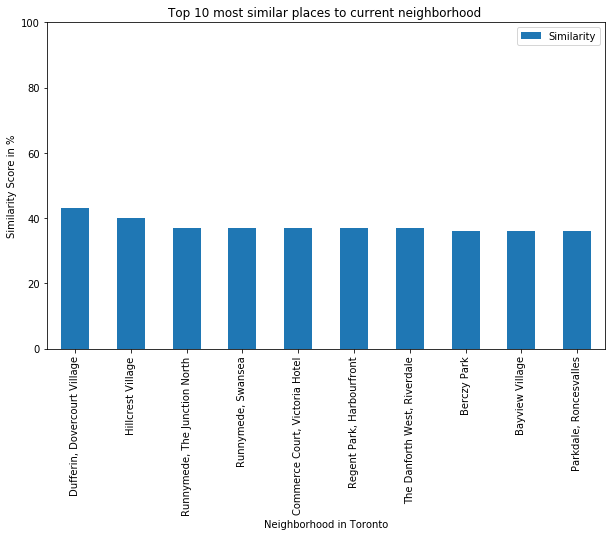

In [48]:
#the top 10 similar neighborhoods on bar plot

top_10.plot(kind = 'bar', x='Neighborhood', y= 'Similarity', figsize=  (10,6))
plt.title('Top 10 most similar places to current neighborhood ')
plt.xlabel('Neighborhood in Toronto')
plt.ylabel('Similarity Score in %')
plt.ylim(0,100)
plt.show()

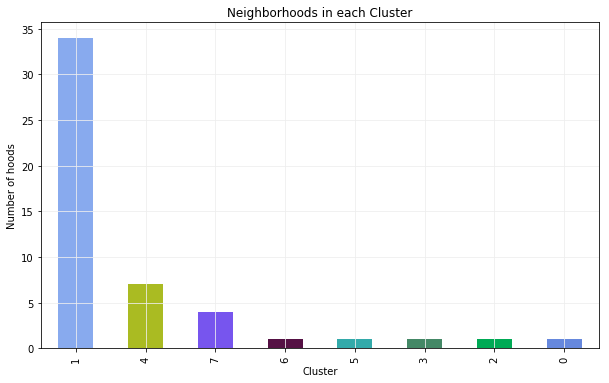

In [49]:
#cluster wise neighborhood distribution in toronto, bar plot

df2['Cluster'].value_counts().plot(kind = 'Bar', stacked = True, color = colors, figsize = (10,6))
plt.title('Neighborhoods in each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of hoods')
plt.grid(color = '#EEEEEE')
plt.show()

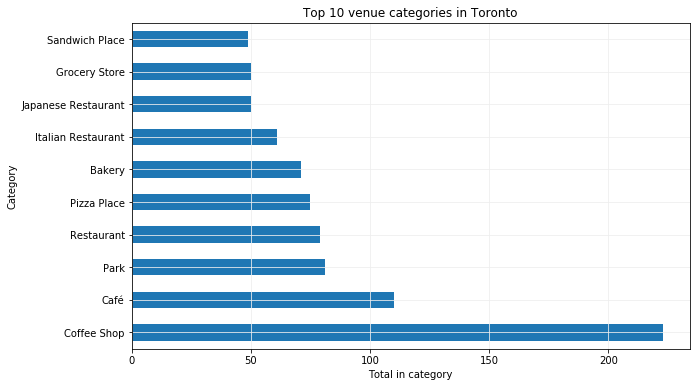

In [50]:
#most popular venues in toronto, bar plot

df3['Category'].value_counts()[0:10].plot(kind = 'Barh', stacked = True, figsize = (10,6))
plt.title('Top 10 venue categories in Toronto')
plt.xlabel('Total in category')
plt.ylabel('Category')
plt.grid(color = '#EEEEEE')
plt.show()

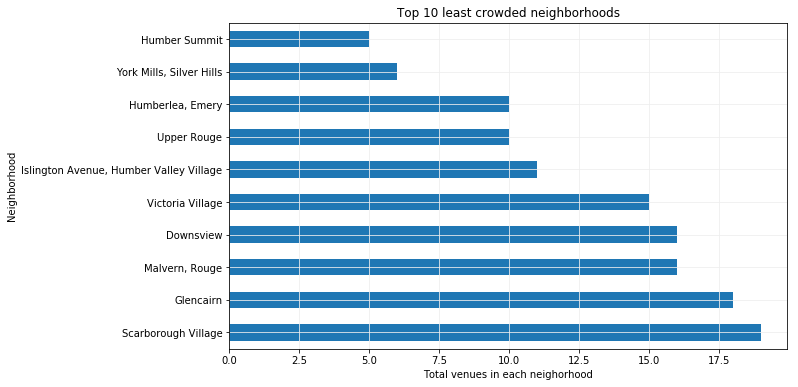

In [51]:
#least crowded neighborhoods in toronto

df3['Neighborhood'].value_counts()[-11:-1].plot(kind = 'Barh', stacked = True, figsize = (10,6))
plt.title('Top 10 least crowded neighborhoods')
plt.xlabel('Total venues in each neighorhood')
plt.ylabel('Neighborhood')
plt.grid(color = '#EEEEEE')
plt.show()

#cannot show most crowded as forsquare only returns 100 venues

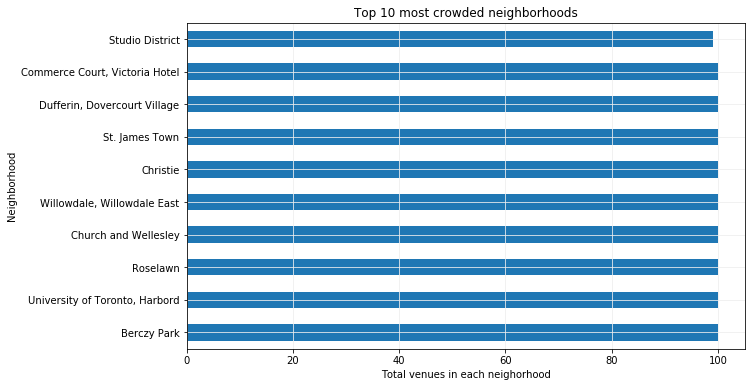

In [52]:
#most crowded neighborhoods in toronto
#foursquare only allows to retrieve top 100 venues

df3['Neighborhood'].value_counts()[0:10].plot(kind = 'Barh', stacked = True, figsize = (10,6))
plt.title('Top 10 most crowded neighborhoods')
plt.xlabel('Total venues in each neighorhood')
plt.ylabel('Neighborhood')
plt.grid(color = '#EEEEEE')
plt.show()

In [53]:
top_10.iloc[:,0:-2]

,Neighborhood,Distance,Similarity
0,"Dufferin, Dovercourt Village",0.217766,43.0
1,Hillcrest Village,0.213072,40.0
2,"Runnymede, The Junction North",0.227713,37.0
3,"Runnymede, Swansea",0.227713,37.0
4,"Commerce Court, Victoria Hotel",0.225398,37.0
5,"Regent Park, Harbourfront",0.222986,37.0
6,"The Danforth West, Riverdale",0.221615,37.0
7,Berczy Park,0.227723,36.0
8,Bayview Village,0.224261,36.0
9,"Parkdale, Roncesvalles",0.219192,36.0
